In [5]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima


In [6]:
# Loading datasets
energy_set = pd.read_csv('energy_dataset.csv', index_col='time', parse_dates=True)
weather_set = pd.read_csv('weather_features.csv')

In [7]:
energy_set.columns = energy_set.columns.str.replace(' ','_').str.replace('-','_')
weather_set.columns = weather_set.columns.str.replace(' ','_').str.replace('-','_')

In [8]:
# Checking for null values in energy dataset
print("Null % in 'Energy-Dataset' are as follows:")
print((energy_set.isnull().sum() / len(energy_set)) * 100)

Null % in 'Energy-Dataset' are as follows:
generation_biomass                               0.054187
generation_fossil_brown_coal/lignite             0.051335
generation_fossil_coal_derived_gas               0.051335
generation_fossil_gas                            0.051335
generation_fossil_hard_coal                      0.051335
generation_fossil_oil                            0.054187
generation_fossil_oil_shale                      0.051335
generation_fossil_peat                           0.051335
generation_geothermal                            0.051335
generation_hydro_pumped_storage_aggregated     100.000000
generation_hydro_pumped_storage_consumption      0.054187
generation_hydro_run_of_river_and_poundage       0.054187
generation_hydro_water_reservoir                 0.051335
generation_marine                                0.054187
generation_nuclear                               0.048483
generation_other                                 0.051335
generation_other_renewable   

In [9]:
# Checking for null values in weather dataset
print("Null % in 'Weather-Dataset' are as follows:")
print((weather_set.isnull().sum() / len(weather_set)) * 100)

Null % in 'Weather-Dataset' are as follows:
dt_iso                 0.0
city_name              0.0
temp                   0.0
temp_min               0.0
temp_max               0.0
pressure               0.0
humidity               0.0
wind_speed             0.0
wind_deg               0.0
rain_1h                0.0
rain_3h                0.0
snow_3h                0.0
clouds_all             0.0
weather_id             0.0
weather_main           0.0
weather_description    0.0
weather_icon           0.0
dtype: float64


In [10]:
# Handling time column if it exists
if 'time' in energy_set.columns:
    energy_set['time'] = pd.to_datetime(energy_set['time'], utc=True)
    energy_set.set_index('time', inplace=True)
else:
    print("The 'time' column doesn't exist in the DataFrame.")


The 'time' column doesn't exist in the DataFrame.


In [11]:
# Removing NaN or 0-filled columns
zero_val_cols = ['generation_marine',
                 'generation_geothermal',
                 'generation_fossil_peat',
                 'generation_wind_offshore',
                 'generation_fossil_oil_shale',
                 'forecast_wind_offshore_eday_ahead',
                 'generation_fossil_coal_derived_gas',
                 'generation_hydro_pumped_storage_aggregated']

energy_set.drop(columns=zero_val_cols, inplace=True)


In [12]:
# Data types of weather_set
weather_set.dtypes

dt_iso                  object
city_name               object
temp                   float64
temp_min               float64
temp_max               float64
pressure                 int64
humidity                 int64
wind_speed               int64
wind_deg                 int64
rain_1h                float64
rain_3h                float64
snow_3h                float64
clouds_all               int64
weather_id               int64
weather_main            object
weather_description     object
weather_icon            object
dtype: object

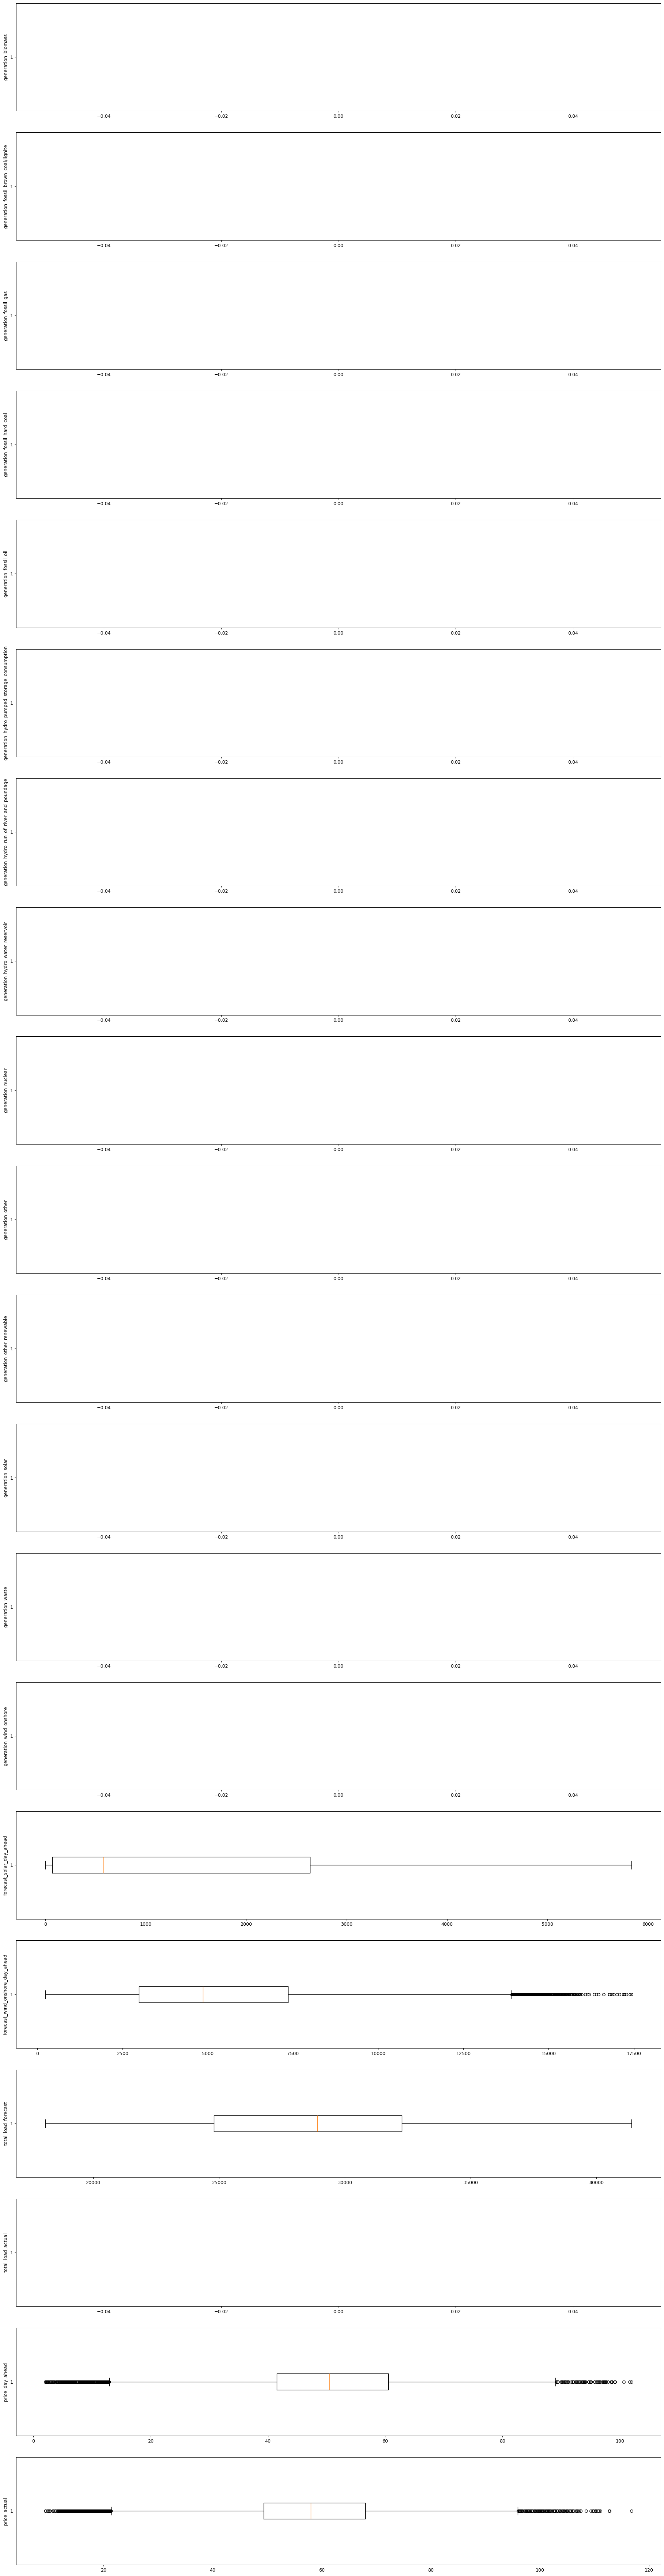

In [13]:
# Checking for outliers in energy dataset using Box Plot
fig, axs = plt.subplots(nrows=20, ncols=1, dpi=91, figsize=(25, 100))
i = 0
for col in energy_set.columns:
    axs[i].boxplot(energy_set[col], vert=False)
    axs[i].set_ylabel(col)
    i += 1
plt.show()


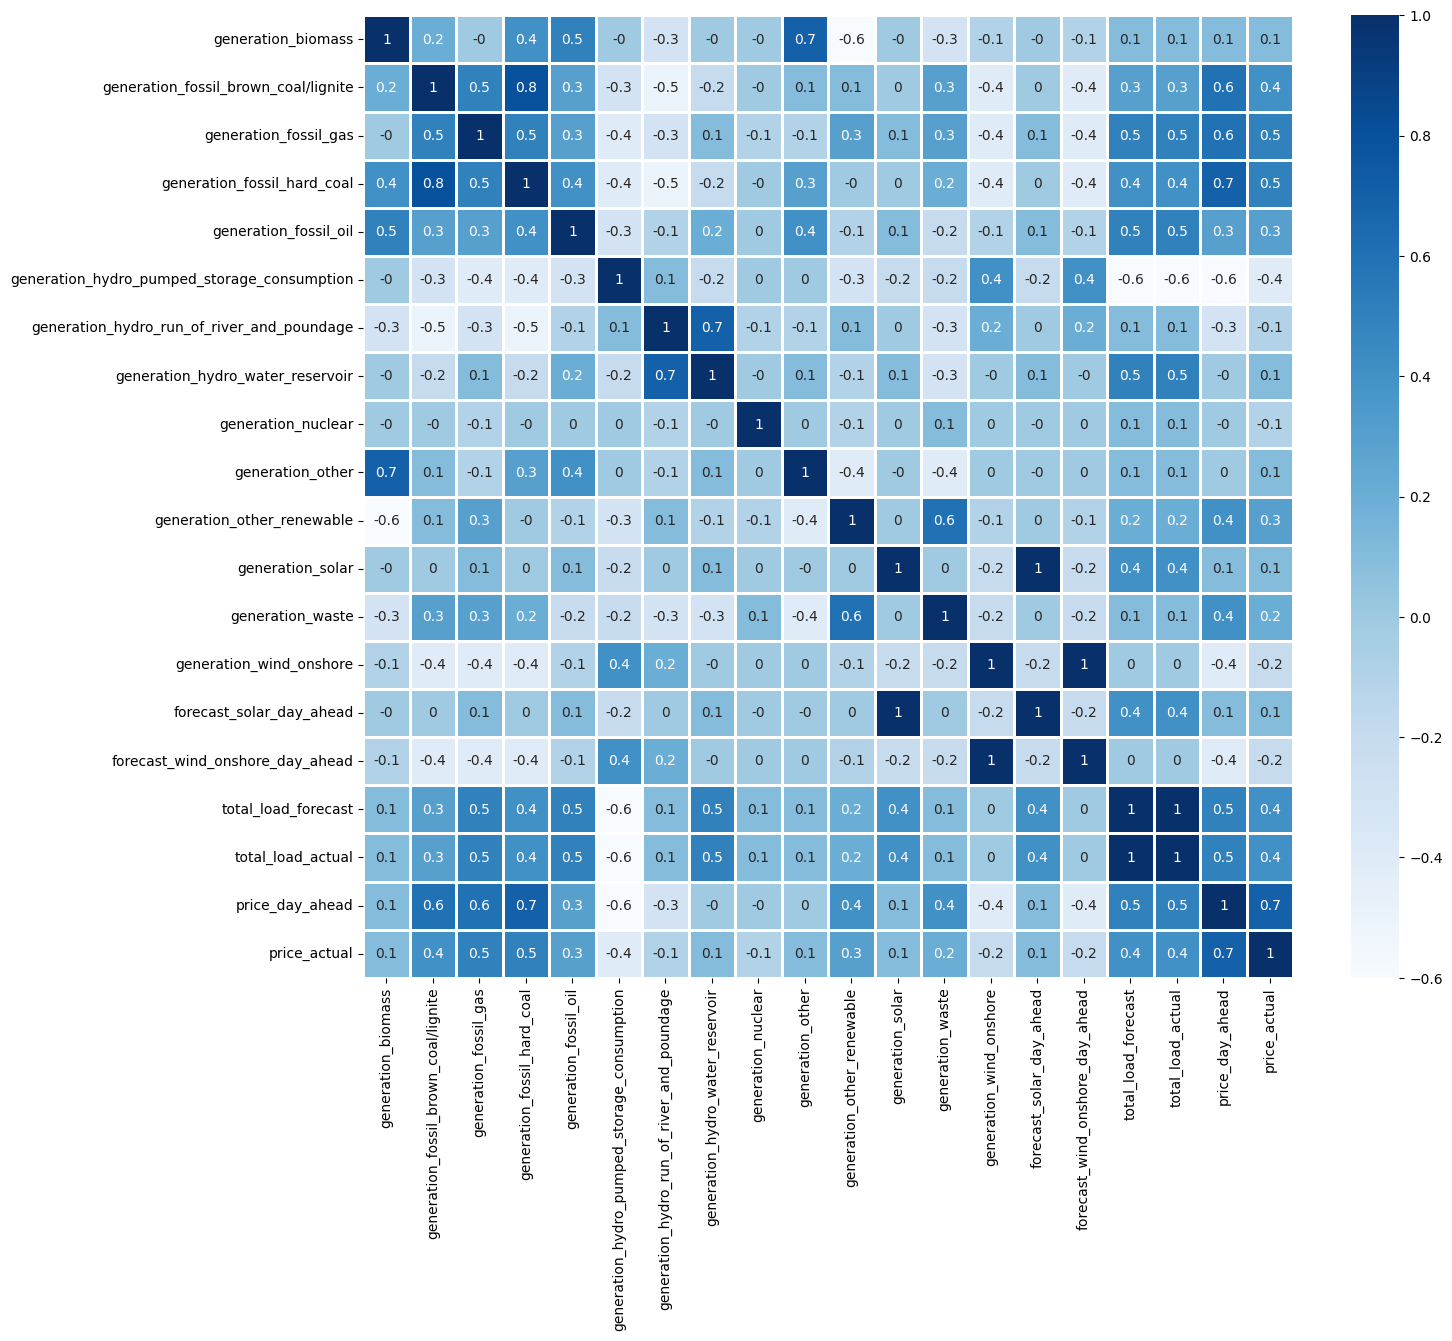

In [14]:
# Correlation heatmap
plt.figure(figsize=(15, 12.5))
sns.heatmap(round(energy_set.corr(), 1), annot=True, cmap='Blues', linewidth=0.9)
plt.show()


In [1]:
# Check for stationarity and apply differencing if necessary
# Stationarity means that the statistical properties of a a time series (or rather the process generating it) do not change over time. Stationarity is important because many useful analytical tools and statistical tests and models rely on it
def ad_test(dataset):
    dftest = adfuller(dataset, autolag='AIC')
    return dftest[1]


In [16]:
# Perform differencing if necessary to make the time series stationary
energy_set['price_actual_diff'] = energy_set['price_actual'].diff()
energy_set.dropna(inplace=True)

In [17]:
# Determine the order of ARIMA model using auto_arima
model_order = auto_arima(energy_set['price_actual_diff'], seasonal=False, stepwise=True, trace=True)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=175571.171, Time=5.61 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=190198.879, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=180245.853, Time=0.39 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=181653.387, Time=0.91 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=179864.272, Time=3.30 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=175923.618, Time=4.14 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=175567.703, Time=8.99 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=175622.641, Time=4.46 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=175517.049, Time=9.24 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=175519.114, Time=6.01 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=175522.447, Time=6.82 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=inf, Time=16.47 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=175432.028, Time=10.85 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=175563.752, Time=5.30 sec
 ARIMA(3,0

In [18]:
# Fit SARIMA model
p, d, q = model_order.order
model = SARIMAX(energy_set['price_actual'], order=(p, d, q))
results = model.fit()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.94811D+02    |proj g|=  3.84822D+02


 This problem is unconstrained.



At iterate    5    f=  2.76654D+00    |proj g|=  4.11643D-01

At iterate   10    f=  2.59175D+00    |proj g|=  1.74207D-02

At iterate   15    f=  2.58860D+00    |proj g|=  3.84748D-03

At iterate   20    f=  2.57689D+00    |proj g|=  5.67495D-02

At iterate   25    f=  2.57159D+00    |proj g|=  8.03589D-03

At iterate   30    f=  2.56801D+00    |proj g|=  2.56892D-02

At iterate   35    f=  2.51725D+00    |proj g|=  3.95992D-02

At iterate   40    f=  2.48998D+00    |proj g|=  1.07096D-01

At iterate   45    f=  2.47030D+00    |proj g|=  3.10071D-02

At iterate   50    f=  2.46370D+00    |proj g|=  1.11144D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [19]:
# Forecast future values
forecast_period = 24  # Adjust as needed
forecast = results.get_forecast(steps=forecast_period)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


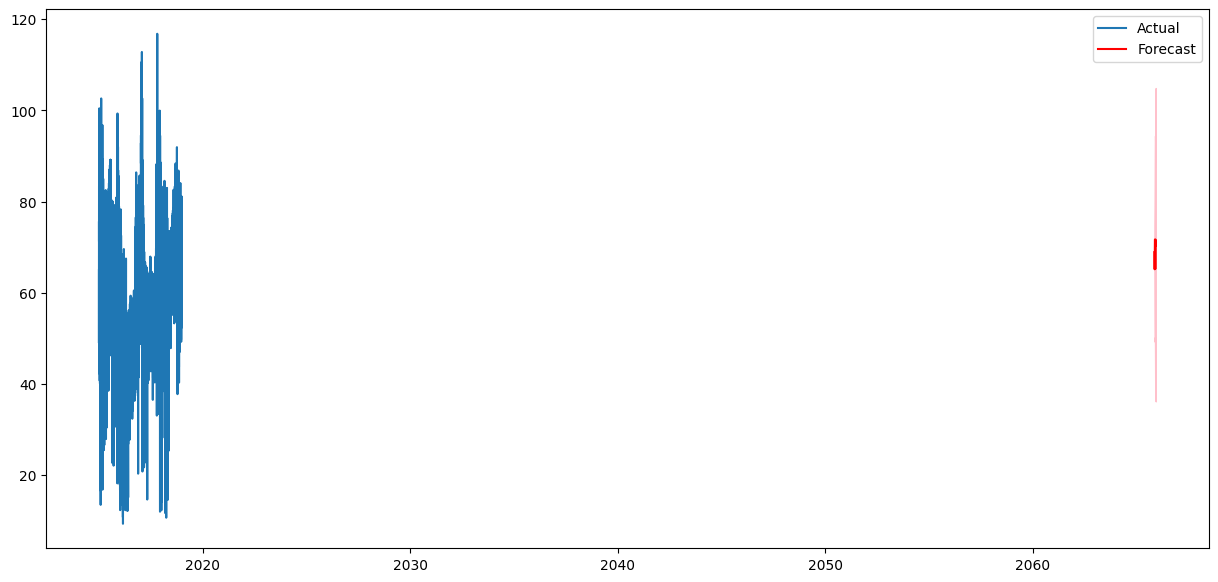

In [21]:
# Plot the actual and forecasted values
plt.figure(figsize=(15, 7))
plt.plot(energy_set.index, energy_set['price_actual'], label='Actual')
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, label='Forecast', color='red')
plt.fill_between(forecast.predicted_mean.index, forecast.conf_int()['lower price_actual'], forecast.conf_int()['upper price_actual'], color='pink')
plt.legend()
plt.show()


In [22]:
# Define the number of future periods to forecast
forecast_periods = 24  # Adjust as needed


In [23]:
# Forecast future energy prices
forecasted_values = results.get_forecast(steps=forecast_periods)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [24]:
# Access the predicted values
predicted_mean = forecasted_values.predicted_mean


In [25]:
# Access the confidence intervals
lower_ci = forecasted_values.conf_int()['lower price_actual']
upper_ci = forecasted_values.conf_int()['upper price_actual']


In [26]:
# Print the forecasted values and confidence intervals
for i, (forecast_mean, forecast_lower, forecast_upper) in enumerate(zip(predicted_mean, lower_ci, upper_ci), start=1):
    print(f"Period {i}: Forecasted Price = {forecast_mean:.2f}, CI: [{forecast_lower:.2f}, {forecast_upper:.2f}]")


Period 1: Forecasted Price = 68.90, CI: [63.31, 74.50]
Period 2: Forecasted Price = 67.20, CI: [57.99, 76.41]
Period 3: Forecasted Price = 65.82, CI: [54.04, 77.60]
Period 4: Forecasted Price = 65.15, CI: [51.30, 79.01]
Period 5: Forecasted Price = 65.36, CI: [49.76, 80.97]
Period 6: Forecasted Price = 66.40, CI: [49.28, 83.51]
Period 7: Forecasted Price = 67.97, CI: [49.53, 86.42]
Period 8: Forecasted Price = 69.67, CI: [50.02, 89.32]
Period 9: Forecasted Price = 71.03, CI: [50.25, 91.80]
Period 10: Forecasted Price = 71.69, CI: [49.83, 93.54]
Period 11: Forecasted Price = 71.47, CI: [48.55, 94.39]
Period 12: Forecasted Price = 70.44, CI: [46.46, 94.43]
Period 13: Forecasted Price = 68.88, CI: [43.84, 93.92]
Period 14: Forecasted Price = 67.20, CI: [41.11, 93.29]
Period 15: Forecasted Price = 65.85, CI: [38.75, 92.95]
Period 16: Forecasted Price = 65.20, CI: [37.14, 93.27]
Period 17: Forecasted Price = 65.42, CI: [36.45, 94.39]
Period 18: Forecasted Price = 66.44, CI: [36.63, 96.25]
P

 Successfully obtained the forecasted prices and their corresponding confidence intervals for the specified future periods.